In [1]:

########################################################################
# choose machine type and id
S1 = 'id_00'
S2 = 'id_02'
MACHINE = 'slider'
FILE = 'slider_id04_id06_original.pth'
xumx_slider_model_path = '/hdd/hdd1/sss/xumx/1013_9_slider0246_fix_control/checkpoints/epoch=198-step=3382.ckpt'
xumx_valve_model_path = '/hdd/hdd1/sss/xumx/1013_8_valve0248_fix_control/checkpoints/epoch=214-step=4944.ckpt'
xumx_model_path = xumx_valve_model_path if MACHINE == 'valve' else xumx_slider_model_path
ae_path_base = '/hdd/hdd1/kjc/xumx/ae/cont'

machine_types = [S1, S2]
num_eval_normal = 250

plot_size = 10

########################################################################


In [2]:
########################################################################
# import default python-library
########################################################################
import pickle
import os
import sys
import glob

import numpy
import numpy as np
import librosa
import librosa.core
import librosa.feature
import yaml
import logging
import random

from tqdm import tqdm
from sklearn import metrics

import torch
import torch.nn as nn
from asteroid.models import XUMXControl
import museval


from utils import *
from model import TorchModel
########################################################################


########################################################################
# version
########################################################################
__versions__ = "1.0.3"
########################################################################



########################################################################
# feature extractor
########################################################################


def generate_label(y):
        # np, [c, t]
    channels = y.shape[0]
    frames = 5
    rms_fig = librosa.feature.rms(y=y)
    #[c, 1, 313]

    rms_tensor = torch.tensor(rms_fig).permute(0, 2, 1)
    # [channel, time, 1]
    rms_trim = rms_tensor.expand(-1, -1, 512).reshape(channels, -1)[:, :160000]
    # [channel, time]

    rms_trim_spec = torch.stack([torch.tensor(rms_fig[:, 0, i:i+rms_fig.shape[2]-frames+1]) for i in range(frames)], dim=2)
    #[c, 313-4, 5]

    if MACHINE == 'valve':
        k = int(y.shape[1]*0.8)
        min_threshold, _ = torch.kthvalue(rms_trim[0, :], k)
    else:
        min_threshold = (torch.max(rms_trim) + torch.min(rms_trim))/2
    
    label = (rms_trim > min_threshold).type(torch.float)
        #[channel, time]
    label_spec = (rms_trim_spec > min_threshold).type(torch.float) 
    return label, label_spec


def train_file_to_mixture_wav_label(filename):
    machine_type = os.path.split(os.path.split(os.path.split(filename)[0])[0])[1]
    ys = 0
    active_label_sources = {}
    for machine in machine_types:
        src_filename = filename.replace(machine_type, machine)
        sr, y = file_to_wav_stereo(src_filename)
        label, _ = generate_label(y)
        active_label_sources[machine] = label
        ys = ys + y
        if machine == machine_type:
            gt_y = y

    return sr, ys, active_label_sources, gt_y


def eval_file_to_mixture_wav_label(filename):
    machine_type = os.path.split(os.path.split(os.path.split(filename)[0])[0])[1]
    ys = 0
    gt_wav = {}
    active_label_sources = {}
    active_spec_label_sources = {}
    for normal_type in machine_types:
        if normal_type == machine_type:
            src_filename = filename
        else:
            src_filename = filename.replace(machine_type, normal_type).replace('abnormal', 'normal')
        sr, y = file_to_wav_stereo(src_filename)
        
        # if normal_type != machine_type:
        #     delay = random.randint(0, 16000)
        #     audio_len = y.shape[1]  
        #     y = np.concatenate([np.zeros_like(y)[:, :delay], y[:, :audio_len - delay]], axis=1)
        ys = ys + y
        label, spec_label = generate_label(y)
        active_label_sources[normal_type] = label
        active_spec_label_sources[normal_type] = spec_label
        gt_wav[normal_type] = y
    
    return sr, ys, gt_wav, active_label_sources, active_spec_label_sources

def get_overlap_ratio(signal1, signal2):
    return torch.sum(torch.logical_and(signal1, signal2)) / torch.sum(torch.logical_or(signal1, signal2))


class XUMXSystem(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.model = None


def xumx_model(path):
    
    x_unmix = XUMXControl(
        window_length=4096,
        input_mean=None,
        input_scale=None,
        nb_channels=2,
        hidden_size=512,
        in_chan=4096,
        n_hop=1024,
        sources=['s1', 's2', 's3', 's4'][:len(machine_types)],
        max_bin=bandwidth_to_max_bin(16000, 4096, 16000),
        bidirectional=True,
        sample_rate=16000,
        spec_power=1,
        return_time_signals=True,
    )

    conf = torch.load(path, map_location="cpu")

    system = XUMXSystem()
    system.model = x_unmix

    system.load_state_dict(conf['state_dict'], strict=False)

    return system.model



def train_list_to_mix_sep_spec_vector_array(file_list,
                         msg="calc...",
                         n_mels=64,
                         frames=5,
                         n_fft=1024,
                         hop_length=512,
                         power=2.0,
                         sep_model=None,
                         target_source=None):
    """
    convert the file_list to a vector array.
    file_to_vector_array() is iterated, and the output vector array is concatenated.
    file_list : list [ str ]
        .wav filename list of dataset
    msg : str ( default = "calc..." )
        description for tqdm.
        this parameter will be input into "desc" param at tqdm.
    return : numpy.array( numpy.array( float ) )
        training dataset (when generate the validation data, this function is not used.)
        * dataset.shape = (total_dataset_size, feature_vector_length)
    """
    # 01 calculate the number of dimensions
    dims = n_mels * frames

    # 02 loop of file_to_vectorarray
    for idx in tqdm(range(len(file_list)), desc=msg):
        target_type = os.path.split(os.path.split(os.path.split(file_list[idx])[0])[0])[1]

        sr, mixture_y, active_label_sources = train_file_to_mixture_wav_label(file_list[idx])
            
        active_labels = torch.stack([active_label_sources[src] for src in machine_types])
        _, time = sep_model(torch.Tensor(mixture_y).unsqueeze(0).cuda(), active_labels.unsqueeze(0).cuda())
        # [src, b, ch, time]
        if target_source is not None:
            target_idx = machine_types.index(target_source)
        else:
            target_idx = machine_types.index(target_type)
        ys = time[target_idx, 0, 0, :].detach().cpu().numpy()
        
        vector_array = wav_to_spec_vector_array(sr, ys,
                                            n_mels=n_mels,
                                            frames=frames,
                                            n_fft=n_fft,
                                            hop_length=hop_length,
                                            power=power)

        if idx == 0:
            dataset = numpy.zeros((vector_array.shape[0] * len(file_list), dims), float)

        dataset[vector_array.shape[0] * idx: vector_array.shape[0] * (idx + 1), :] = vector_array

    return dataset


class AEDataset(torch.utils.data.Dataset):
    def __init__(self, 
            sep_model, 
            file_list,
            param,
            target_source=None,
            ):
        self.sep_model = sep_model
        self.file_list = file_list
        self.target_source = target_source

        self.data_vector = train_list_to_mix_sep_spec_vector_array(self.file_list,
                                            msg="generate train_dataset",
                                            n_mels=param["feature"]["n_mels"],
                                            frames=param["feature"]["frames"],
                                            n_fft=param["feature"]["n_fft"],
                                            hop_length=param["feature"]["hop_length"],
                                            power=param["feature"]["power"],
                                            sep_model = self.sep_model,
                                            target_source=target_source)
        
    
    def __getitem__(self, index):
        return torch.Tensor(self.data_vector[index, :])
    
    def __len__(self):
        return self.data_vector.shape[0]


def dataset_generator(target_dir,
                      normal_dir_name="normal",
                      abnormal_dir_name="abnormal",
                      ext="wav"):
    """
    target_dir : str
        base directory path of the dataset
    normal_dir_name : str (default="normal")
        directory name the normal data located in
    abnormal_dir_name : str (default="abnormal")
        directory name the abnormal data located in
    ext : str (default="wav")
        filename extension of audio files 
    return : 
        train_data : numpy.array( numpy.array( float ) )
            training dataset
            * dataset.shape = (total_dataset_size, feature_vector_length)
        train_files : list [ str ]
            file list for training
        train_labels : list [ boolean ] 
            label info. list for training
            * normal/abnormal = 0/1
        eval_files : list [ str ]
            file list for evaluation
        eval_labels : list [ boolean ] 
            label info. list for evaluation
            * normal/abnormal = 0/1
    """

    logger.info("target_dir : {}".format(target_dir))

    # 01 normal list generate
    normal_files = sorted(glob.glob(
        os.path.abspath("{dir}/{normal_dir_name}/*.{ext}".format(dir=target_dir,
                                                                 normal_dir_name=normal_dir_name,
                                                                ext=ext))))
    normal_len = [len(glob.glob(
        os.path.abspath("{dir}/{normal_dir_name}/*.{ext}".format(dir=target_dir.replace(S1, mt),
                                                                 normal_dir_name=normal_dir_name,
                                                                 ext=ext)))) for mt in machine_types]   #dataset 중에서 가장 짧은 것 기준
    normal_len = min(min(normal_len), len(normal_files))
    normal_files = normal_files[:normal_len]


    normal_labels = numpy.zeros(len(normal_files))
    if len(normal_files) == 0:
        logger.exception("no_wav_data!!")


    # 02 abnormal list generate
    abnormal_files = []
    for mt in machine_types:
        abnormal_files.extend(sorted(glob.glob(
            os.path.abspath("{dir}/{abnormal_dir_name}/*.{ext}".format(dir=target_dir.replace(S1, mt),
                                                                   abnormal_dir_name=abnormal_dir_name,
                                                                 ext=ext)))))                                               
    abnormal_labels = numpy.ones(len(abnormal_files))
    if len(abnormal_files) == 0:
        logger.exception("no_wav_data!!")

    # 03 separate train & eval
    train_files = normal_files[num_eval_normal:]
    train_labels = normal_labels[num_eval_normal:]
    eval_normal_files = sum([[fan_file.replace(S1, machine_type) for fan_file in normal_files[:num_eval_normal]] for machine_type in machine_types], [])
    eval_files = numpy.concatenate((eval_normal_files, abnormal_files), axis=0)
    eval_labels = numpy.concatenate((np.repeat(normal_labels[:num_eval_normal], len(machine_types)), abnormal_labels), axis=0)  ##TODO 
    logger.info("train_file num : {num}".format(num=len(train_files)))
    logger.info("eval_file  num : {num}".format(num=len(eval_files)))

    return train_files, train_labels, eval_files, eval_labels


########################################################################



In [3]:
def get_data(sep_model, files, param):
    n_mels=param["feature"]["n_mels"]
    frames=param["feature"]["frames"]
    n_fft=param["feature"]["n_fft"]
    hop_length=param["feature"]["hop_length"]
    power=param["feature"]["power"]
    
    result = []
    
    for file in files:
        target_type = os.path.split(os.path.split(os.path.split(file)[0])[0])[1]
        
        active_label_sources = {}
        gt_wav = {}
        sep_wav = {}
        mixture_wav = 0
        for machine in machine_types:
            src_filename = file.replace(target_type, machine)
            if machine != target_type:
                src_filename = src_filename.replace('abnormal', 'normal')
            sr, y = file_to_wav_stereo(src_filename)
            label, _ = generate_label(y)
            mixture_wav = mixture_wav + y
            active_label_sources[machine] = label
            gt_wav[machine] = y
            #[ch, time]
        
        active_labels = torch.stack([active_label_sources[src] for src in machine_types])
        _, time = sep_model(torch.Tensor(mixture_wav).unsqueeze(0).cuda(), active_labels.unsqueeze(0).cuda())
        
        for machine in machine_types:
            machine_idx = machine_types.index(machine)
            sep_wav[machine] = time[machine_idx, 0, :, :].detach().cpu().numpy()
            #[ch, time]
        
        time_len = min(gt_wav[S1].shape[1], sep_wav[S1].shape[1])
        wav_array = np.stack([gt_wav[S1][:, :time_len], gt_wav[S2][:, :time_len], mixture_wav[:, :time_len], sep_wav[S1][:, :time_len], sep_wav[S2][:, :time_len]])
        # [5, ch, time]
        spec_list = []
        
        for i in range(5):
            vector_array = wav_to_spec_vector_array(sr, wav_array[i, 0, :],
                                                n_mels=n_mels,
                                                frames=frames,
                                                n_fft=n_fft,
                                                hop_length=hop_length,
                                                power=power)
            # [309, 320]
            spec_list.append(vector_array)
        spec_array = np.stack(spec_list)
        # [5, 309, 320]
        result.append((wav_array, spec_array))
    return result
        
    

In [4]:

# load parameter yaml
with open("baseline.yaml") as stream:
    param = yaml.safe_load(stream)

# set random seed fixed
fix_seed(param['seed'])


target_dir = "{base}/6dB/{machine}/{source}".format(base=param["base_directory"], machine = MACHINE, source = S1)

sep_model = xumx_model(xumx_model_path)
sep_model = sep_model.cuda()
sep_model.eval()


train_files, train_labels, eval_files, eval_labels = dataset_generator(target_dir)

train_idx = np.random.choice(range(len(train_files)), size=plot_size,  replace=False)
eval_idx = np.random.choice(range(num_eval_normal * 2, len(eval_files)), size=plot_size,  replace=False)

train_files_subset = np.array(train_files)[train_idx]
train_labels_subset = train_labels[train_idx]
eval_files_subset = eval_files[eval_idx]
eval_labels_subset = eval_labels[eval_idx]

normal_data = get_data(sep_model, train_files_subset, param)
abnormal_data = get_data(sep_model, eval_files_subset, param)


2022-10-18 21:20:13,322 - INFO - target_dir : /dev/shm/mimii/6dB/slider/id_00
2022-10-18 21:20:13,330 - INFO - train_file num : 818
2022-10-18 21:20:13,330 - INFO - eval_file  num : 1123
/home/kjc/.conda/envs/asteroid/lib/python3.8/site-packages/torch/functional.py:770: UserWarning: istft will require a complex-valued input tensor in a future PyTorch release. Matching the output from stft with return_complex=True.  (Triggered internally at  /opt/conda/conda-bld/pytorch_1646755903507/work/aten/src/ATen/native/SpectralOps.cpp:950.)
  return _VF.istft(input, n_fft, hop_length, win_length, window, center,  # type: ignore[attr-defined]


In [5]:
from sklearn.manifold import TSNE

src, l1, l2 = normal_data[0][0].shape

data = []
labels = []
for (wav, spec) in normal_data:
    data.append(wav.reshape(src * l1, l2))
    labels = labels + ['blue'] * l1
    labels = labels + ['red'] * l1
    labels = labels + ['green'] * l1
    labels = labels + ['black'] * l1
    labels = labels + ['orange'] * l1

data_concat = np.concatenate(data, axis=0)


tsne = TSNE(n_components = 2).fit_transform(data_concat)

/home/kjc/.conda/envs/asteroid/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kjc/.conda/envs/asteroid/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


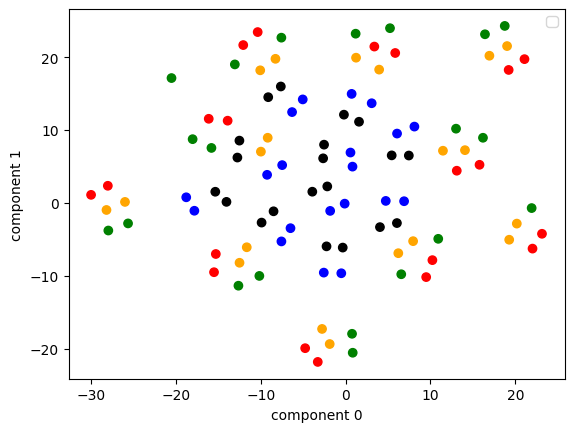

In [6]:
import matplotlib.pyplot as plt

# target 별 시각화
plt.scatter(tsne[:, 0],tsne[:, 1], color = labels)

plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend()
plt.show()

In [7]:
from sklearn.manifold import TSNE

src, l1, l2 = normal_data[0][1].shape

data = []
labels = []

for (wav, spec) in normal_data:
    data.append(spec.reshape(src * l1, l2))
    
    
for (wav, spec) in abnormal_data:
    data.append(spec.reshape(src * l1, l2))

data_concat = np.concatenate(data, axis=0)


tsne = TSNE(n_components = 2).fit_transform(data_concat)

/home/kjc/.conda/envs/asteroid/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/kjc/.conda/envs/asteroid/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


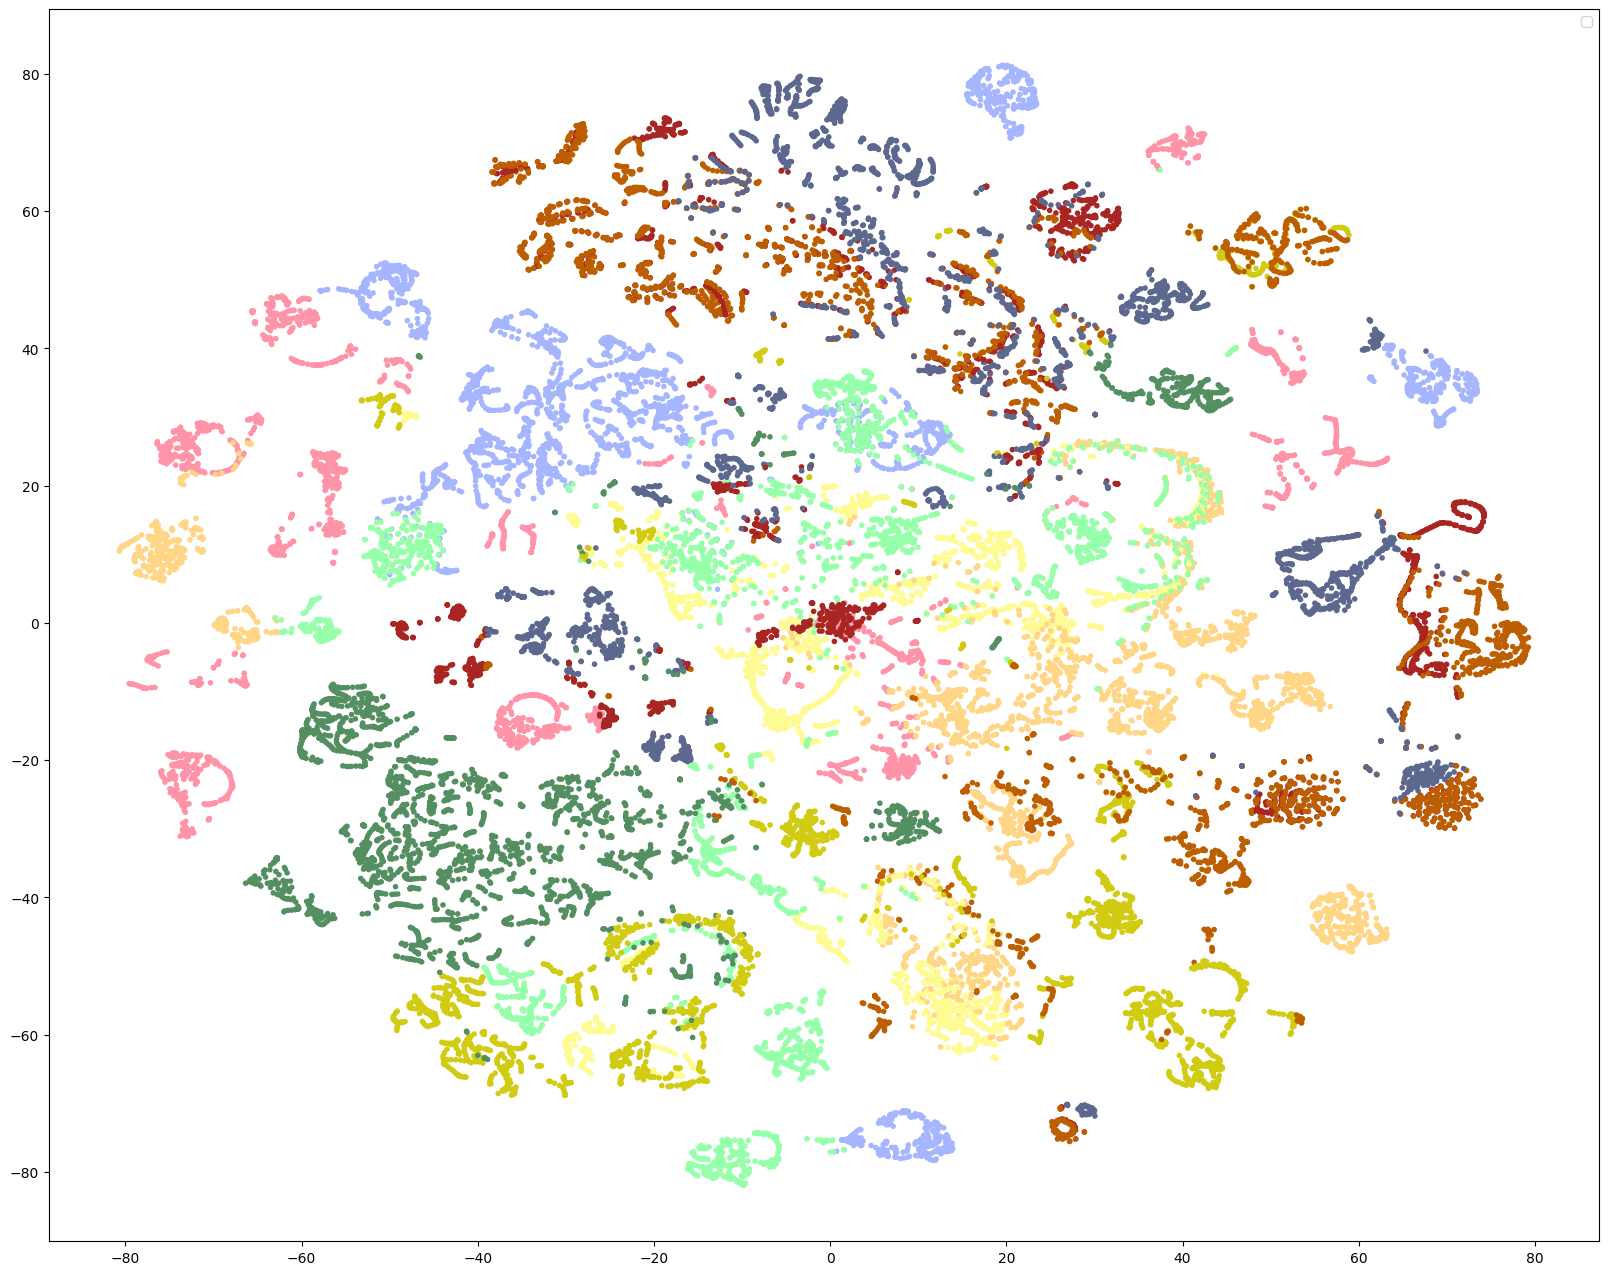

In [11]:
import matplotlib.pyplot as plt

labelss = []

for (wav, spec) in normal_data:
    labelss = labelss + ['#FF94A8'] * l1               # normal / src1      / light red
    labelss = labelss + ['#FFFB93'] * l1               # normal / src2      / light yellow
    labelss = labelss + ['#FFD586'] * l1               # normal / mix       / light orange
    labelss = labelss + ['#A5B6FF'] * l1               # normal / sep_src1  / light blue
    labelss = labelss + ['#96FFA9'] * l1               # normal / sep_src2  / light green
    
    
for (wav, spec) in abnormal_data:
    labelss = labelss + ['#A82521'] * l1               # abnormal / src1      / dark red
    labelss = labelss + ['#D1CB11'] * l1               # abnormal / src2      / dark yellow
    labelss = labelss + ['#BD5E00'] * l1               # abnormal / mix       / dark orange
    labelss = labelss + ['#5D688F'] * l1               # abnormal / sep_src1  / dark blue
    labelss = labelss + ['#548F62'] * l1               # abnormal / sep_src2  / dark green


plt.figure(figsize=(20,16))
plt.scatter(tsne[:, 0],tsne[:, 1], color = labelss, marker='.')
plt.legend()
plt.show()